<a href="https://colab.research.google.com/github/walaabouzar/Graph-Coloring-Problem-/blob/main/Graph_Coloring_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import necessary libraries**

In [ ]:
import random
import matplotlib.pyplot as plt
import random
import numpy as np
from multiprocessing import Pool
import csv
import itertools


# **Open file**

In [ ]:
f = open("/content/test1.txt")
data = f.read()
first_line = data.split('\n', 1)[0] # read first line

P, V , E = first_line.strip().split()
V = int(V)
E = int(E)
print(P,V,E)

p 138 986


In [ ]:
f = open("/content/test2.txt")
data = f.read()
first_line = data.split('\n', 1)[0] # read first line

P, V , E = first_line.strip().split()
V = int(V)
E = int(E)
print(P,V,E)

p 500 62624


In [ ]:
f = open("/content/test3.txt")
data = f.read()
first_line = data.split('\n', 1)[0] # read first line

P, V , E = first_line.strip().split()
V = int(V)
E = int(E)
print(P,V,E)

p 1000 246708


In [ ]:
f = open("/content/test4.txt")
data = f.read()
first_line = data.split('\n', 1)[0] # read first line

P, V , E = first_line.strip().split()
V = int(V)
E = int(E)
print(P,V,E)

p 900 307350


In [ ]:
a_file = open("/content/test1.txt")

lines = a_file.readlines()[1:]
print(range(len(lines)))
for line in lines:
    e, u, v = line.rstrip().strip().split()
    #print(e, u, v)

range(0, 986)


In [ ]:
a_file = open("/content/test2.txt")

lines = a_file.readlines()[1:]
print(range(len(lines)))
for line in lines:
    e, u, v = line.rstrip().strip().split()
    #print(e, u, v)

range(0, 62624)


In [ ]:
a_file = open("/content/test3.txt")

lines = a_file.readlines()[1:]
print(range(len(lines)))
for line in lines:
    e, u, v = line.rstrip().strip().split()
    #print(e, u, v)

range(0, 246708)


In [ ]:
a_file = open("/content/test4.txt")

lines = a_file.readlines()[1:]
print(range(len(lines)))
for line in lines:
    e, u, v = line.rstrip().strip().split()
    #print(e, u, v)

range(0, 307350)


# GA

# **Fine tuning parameters**

# **Grid search**

In [ ]:
import time  # Import the time module

class GraphColorGA:
    def __init__(self, V, edges, population_size, generations, initial_mutation_rate, alpha, beta):
        self.V = V
        self.edges = edges
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = initial_mutation_rate  # Initial mutation rate
        self.alpha = alpha  # Weight for conflicts
        self.beta = beta  # Weight for number of colors


        # Initialize CSV file for results
        self.csv_filename = "results3.csv"
        with open(self.csv_filename, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Generation", "Number of Colors", "Fitness", "Mutation Rate", "Diversity"])  # Updated CSV headers

        # Initialize population and maximum number of colors
        self.max_colors = V  # Start with all vertices potentially having unique colors
        self.population = [self.random_coloring() for _ in range(population_size)]

        # Track the best fitness score and execution time
        self.best_fitness = float('inf')  # Initialize to infinity (lower is better)
        self.execution_time = None  # To store the execution time

    def random_coloring(self):
        """Generate a random coloring using colors in [0, max_colors-1]."""
        return [random.randint(0, self.max_colors - 1) for _ in range(self.V)]

    def fitness(self, coloring):
        """
        Evaluate the quality of a coloring.
        Optimized to avoid redundant computations.
        """
        num_colors = len(set(coloring))  # Number of unique colors
        conflicts = sum(1 for u, v in self.edges if coloring[u] == coloring[v])  # Count conflicts
        penalty_conflicts = conflicts ** 1.5
        penalty_colors = num_colors ** 1.5
        return self.alpha * penalty_conflicts + self.beta * penalty_colors

    def evaluate_fitness_parallel(self, population):
        """
        Evaluate fitness for all individuals in the population in parallel.
        """
        with Pool() as pool:  # Create a pool of worker processes
            fitness_values = pool.map(self.fitness, population)  # Evaluate fitness in parallel
        return fitness_values

    def selection(self):
        """
        Perform tournament selection with parallel fitness evaluation.
        Introduce randomness to maintain diversity.
        """
        new_population = []
        tournament_size = max(5, self.population_size // 5)  # Larger tournaments for better balance

        # Evaluate fitness for the entire population in parallel
        fitness_values = self.evaluate_fitness_parallel(self.population)

        for _ in range(self.population_size):
            if random.random() < 0.1:  # 10% chance of random selection to maintain diversity
                winner_index = random.randint(0, self.population_size - 1)
            else:
                tournament_indices = random.sample(range(self.population_size), tournament_size) #sélectionner un sous-ensemble d'éléments sans répétition
                tournament_fitness = [fitness_values[i] for i in tournament_indices]
                winner_index = tournament_indices[tournament_fitness.index(min(tournament_fitness))]
            new_population.append(self.population[winner_index])
        return new_population

    def crossover(self, parent1, parent2):
        """
        Perform multi-point crossover between two parents and repair the child.
        """
        points = sorted(random.sample(range(1, self.V), 2))  # Two random crossover points
        child = parent1[:points[0]] + parent2[points[0]:points[1]] + parent1[points[1]:]
        child = self.repair_coloring(child)  # Repair the child
        return child

    def mutate(self, coloring):
        """
        Apply mutation to an individual and repair the coloring.
        """
        if random.random() < self.mutation_rate:
            idx = random.randint(0, self.V - 1)
            coloring[idx] = random.randint(0, self.max_colors - 1)  # Mutate within allowed color range
        coloring = self.repair_coloring(coloring)  # Repair the coloring
        return coloring

    def calculate_diversity(self):
        """
        Calculate the average pairwise Hamming distance between individuals in the population.
        """
        total_distance = 0
        num_pairs = 0
        for i in range(len(self.population)):
            for j in range(i + 1, len(self.population)):
                # Hamming distance between two colorings
                distance = sum(1 for c1, c2 in zip(self.population[i], self.population[j]) if c1 != c2)
                total_distance += distance
                num_pairs += 1
        return total_distance / num_pairs if num_pairs > 0 else 0

    def adapt_mutation_rate(self, diversity):
        """
        Adapt the mutation rate based on population diversity.
        Use gradual changes to prevent extreme values.
        """
        diversity_threshold_low = self.V // 10  # Low diversity threshold (less strict)
        diversity_threshold_high = 9 * self.V // 10  # High diversity threshold (more strict)

        if diversity < diversity_threshold_low:
            # Gradual increase to encourage exploration
            self.mutation_rate = min(self.mutation_rate * 1.2, 0.8)
        elif diversity > diversity_threshold_high:
            # Gradual decrease to encourage exploitation
            self.mutation_rate = max(self.mutation_rate * 0.9, 0.05)

    def evolve(self):
        """
        Evolve the population over multiple generations.
        Includes adaptive mutation rate adjustment and diversity maintenance.
        """
        # Record the start time
        start_time = time.time()

        best_valid_solution = None  # To store the best valid solution found
        best_valid_fitness = float('inf')  # Fitness of the best valid solution

        for gen in range(1, self.generations + 1):
            # Selection: Get the best individuals
            selected = self.selection()

            # Create new population through crossover and mutation
            new_population = []
            while len(new_population) < self.population_size:
                p1, p2 = random.sample(selected, 2)  # Select two parents
                child = self.crossover(p1, p2)
                child = self.mutate(child)
                new_population.append(child)

            self.population = new_population

            # Evaluate fitness for the entire population in parallel
            fitness_values = self.evaluate_fitness_parallel(self.population)

            # Find the best coloring in the current generation
            best_index = fitness_values.index(min(fitness_values))
            best_coloring = self.population[best_index]
            best_fitness = fitness_values[best_index]
            num_colors = len(set(best_coloring))

            # Update the best fitness score if a better solution is found
            if best_fitness < self.best_fitness:
                self.best_fitness = best_fitness

            # Check if the coloring is valid (no conflicts)
            conflicts = sum(1 for u, v in self.edges if best_coloring[u] == best_coloring[v])
            if conflicts == 0:  # Valid solution
                if best_fitness < best_valid_fitness:  # Update the best valid solution
                    best_valid_solution = best_coloring
                    best_valid_fitness = best_fitness
                if num_colors < self.max_colors:
                    self.max_colors = num_colors  # Reduce the maximum number of colors

            # Calculate population diversity and adapt mutation rate
            diversity = self.calculate_diversity()
            self.adapt_mutation_rate(diversity)

            # Maintain diversity: Randomly reset part of the population if diversity is too low
            if diversity < self.V // 10:  # Critical diversity threshold
                num_reset = int(0.1 * self.population_size)  # Reset 10% of the population
                self.population[-num_reset:] = [self.random_coloring() for _ in range(num_reset)]

            print(f"Generation: {gen}, Number of Colors: {num_colors}")
            # Print progress and save results to CSV
            if best_valid_solution is not None:
              print("Best valid solution found.")


            self.save_results(gen, num_colors, best_fitness, diversity)

        # Record the end time and calculate execution time
        end_time = time.time()
        self.execution_time = end_time - start_time
        print(f"Execution time: {self.execution_time} seconds")

        # Return the best valid solution found, or the best invalid solution if no valid one exists
        if best_valid_solution is not None:
            print("Best valid solution found.")
            return best_valid_solution
        else:
            print("No valid solution found. Returning the best invalid solution.")
            return min(self.population, key=self.fitness)

    def save_results(self, generation, num_colors, fitness, diversity):
        """Save results to a CSV file."""
        with open(self.csv_filename, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([generation, num_colors, fitness, self.mutation_rate, diversity])

    def solve(self):
        """Solve the graph coloring problem."""
        best_solution = self.evolve()
        num_colors = len(set(best_solution))
        return num_colors, best_solution

    def get_best_fitness(self):
        """
        Return the best fitness score found during evolution.
        """
        return self.best_fitness

    def get_execution_time(self):
        """
        Return the execution time of the GA in seconds.
        """
        return self.execution_time
    def validate_coloring(V, edges, coloring):
        """
        Validates whether the coloring is valid (no adjacent vertices share the same color).
        Returns True if valid, False otherwise.
        """
        for u, v in edges:
            if coloring[u] == coloring[v]:
               print(f"Conflict detected: Vertices {u} and {v} share the same color ({coloring[u]}).")
               return False
        return True
    def repair_coloring(self, coloring):
        """
        Repair a coloring by resolving conflicts.
        """
        for u, v in self.edges:
            if coloring[u] == coloring[v]:
                # Trouver une nouvelle couleur pour v qui ne crée pas de conflit
                available_colors = set(range(self.max_colors))
                for neighbor in self.get_neighbors(v):
                    available_colors.discard(coloring[neighbor])
                if available_colors:
                    coloring[v] = min(available_colors)
        return coloring
    def get_neighbors(self, vertex):
        """
        Get the neighbors of a vertex.
        """
        neighbors = []
        for u, v in self.edges:
            if u == vertex:
                neighbors.append(v)
            elif v == vertex:
                neighbors.append(u)
        return neighbors

 Define a function for GraphColorGAN

In [ ]:
def ga_objective_function(V, edges, population_size, generations, initial_mutation_rate, alpha, beta):
    """
    Wrapper function to run the GraphColorGA and return the best fitness score.
    """
    ga = GraphColorGA(
        V=V,
        edges=edges,
        population_size=population_size,
        generations=generations,
        initial_mutation_rate=initial_mutation_rate,
        alpha=alpha,
        beta=beta
    )
    ga.solve()  # Run the GA
    return ga.get_best_fitness()  # Return the best fitness score

# Read the graph

In [ ]:
# Fonction pour lire un graphe depuis un fichier
def read_graph(file_path):
    with open(file_path) as f:
        data = f.read().strip().split("\n")
    _, V, _ = data[0].split()
    V = int(V)
    edges = [(int(u) - 1, int(v) - 1) for _, u, v in (line.split() for line in data[1:] if line.strip())]
    return V, edges

In [ ]:
if __name__ == '__main__':
    file_path = "/content/test1.txt"

    # Fonction pour lire un graphe depuis un fichier
    def read_graph(file_path):
        with open(file_path) as f:
            data = f.read().strip().split("\n")
        _, V, _ = data[0].split()
        V = int(V)
        edges = [(int(u) - 1, int(v) - 1) for _, u, v in (line.split() for line in data[1:] if line.strip())]
        return V, edges

    # Lire le graphe à partir du fichier
    V, edges = read_graph(file_path)

    # Wrapper function for GraphColorGA
    def ga_objective_function(population_size, initial_mutation_rate, alpha, beta, generations=50):
        """
        Wrapper function to run the GraphColorGA and return the best fitness score.
        """
        ga = GraphColorGA(
            V=V,
            edges=edges,
            population_size=population_size,
            generations=generations,
            initial_mutation_rate=initial_mutation_rate,
            alpha=alpha,
            beta=beta
        )
        ga.solve()  # Run the GA
        return ga.get_best_fitness()  # Return the best fitness score

    # Standalone grid search function
    def grid_search(objective_function, param_grid, fixed_params):
        """
        Perform a grid search over hyperparameters.

        Args:
            objective_function (callable): A function that takes all parameters (both fixed and variable)
                                           as input and returns a fitness score.
            param_grid (dict): Dictionary of hyperparameter ranges to explore.
            fixed_params (dict): Fixed parameters that remain constant across all runs.

        Returns:
            list: A list of results for each hyperparameter combination.
        """
        keys, values = zip(*param_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

        results = []

        for params in param_combinations:
            print(f"Running with params: {params}")

            # Combine fixed parameters and current hyperparameters
            all_params = {**fixed_params, **params}

            # Evaluate the objective function
            fitness_score = objective_function(**all_params)

            # Record the results
            result = {
                "params": all_params,
                "fitness_score": fitness_score
            }
            results.append(result)

            print(f"Finished with fitness score: {fitness_score}")

        return results

    # Paramètres fixes
    fixed_params = {
        "generations": 1000,  # Nombre de générations
        "initial_mutation_rate": 0.05
    }

    # Grille de recherche des hyperparamètres
    param_grid = {
        "population_size": [50, 100],
        "alpha": [5, 10],
        "beta": [2, 4]
    }

    # Exécuter la recherche en grille
    results = grid_search(ga_objective_function, param_grid, fixed_params)

    # Trouver les meilleurs paramètres
    best_result = min(results, key=lambda x: x["fitness_score"])
    print(f"Meilleurs paramètres: {best_result['params']}")
    print(f"Meilleur score de fitness: {best_result['fitness_score']}")

    # Utiliser les meilleurs paramètres pour obtenir la meilleure solution
    best_params = best_result["params"]
    ga = GraphColorGA(
        V=V,
        edges=edges,
        population_size=best_params["population_size"],
        generations=best_params["generations"],
        initial_mutation_rate=best_params["initial_mutation_rate"],
        alpha=best_params["alpha"],
        beta=best_params["beta"]
    )
    best_solution = ga.evolve()

    # Calcul du nombre de couleurs utilisées
    num_colors = len(set(best_solution))

    # Validation de la solution
    def validate_coloring(V, edges, coloring):
        """Validate the coloring by checking for conflicts."""
        for u, v in edges:
            if coloring[u] == coloring[v]:
                return False
        return True

    if validate_coloring(V, edges, best_solution):
        print("La solution est valide: Aucun conflit détecté.")
    else:
        print("La solution n'est pas valide: Conflits détectés.")

    print(f"Nombre de couleurs utilisées: {num_colors}")
    print(f"Meilleure solution: {best_solution}")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Generation: 508, Number of Colors: 14
Best valid solution found.
Generation: 509, Number of Colors: 13
Best valid solution found.
Generation: 510, Number of Colors: 13
Best valid solution found.
Generation: 511, Number of Colors: 13
Best valid solution found.
Generation: 512, Number of Colors: 13
Best valid solution found.
Generation: 513, Number of Colors: 13
Best valid solution found.
Generation: 514, Number of Colors: 13
Best valid solution found.
Generation: 515, Number of Colors: 13
Best valid solution found.
Generation: 516, Number of Colors: 13
Best valid solution found.
Generation: 517, Number of Colors: 13
Best valid solution found.
Generation: 518, Number of Colors: 13
Best valid solution found.
Generation: 519, Number of Colors: 13
Best valid solution found.
Generation: 520, Number of Colors: 13
Best valid solution found.
Generation: 521, Number of Colors: 13
Best valid solution found.
Generation: 

In [ ]:
 def validate_coloring(V, edges, coloring):
        """
        Validates whether the coloring is valid (no adjacent vertices share the same color).
        Returns True if valid, False otherwise.
        """
        for u, v in edges:
            if coloring[u] == coloring[v]:
               print(f"Conflict detected: Vertices {u} and {v} share the same color ({coloring[u]}).")
               return False
        return True

# **Running GA with Best paramters**

# **Test 1**

In [ ]:
if __name__ == '__main__':
    file_path = "/content/test1.txt"

    # Fonction pour lire un graphe depuis un fichier
    def read_graph(file_path):
        with open(file_path) as f:
            data = f.read().strip().split("\n")
        _, V, _ = data[0].split()
        V = int(V)
        edges = [(int(u) - 1, int(v) - 1) for _, u, v in (line.split() for line in data[1:] if line.strip())]
        return V, edges

    V, edges = read_graph(file_path)

    population_size = 100
    generations = 1000
    mutation_rate = 0.05
    alpha = 10
    beta = 2

    # Création de l'instance du GA
    ga = GraphColorGA(V, edges,population_size, generations, mutation_rate, alpha, beta )

    # Utilisation de la méthode evolve() pour obtenir la meilleure solution
    best_solution = ga.evolve()

    # Calcul du nombre de couleurs utilisées (par le nombre de couleurs uniques dans la solution)
    num_colors = len(set(best_solution))

    # Validation de la solution
    if validate_coloring(V, edges, best_solution):
        print("La solution est valide: Aucun conflit détecté.")
    else:
        print("La solution n'est pas valide: Conflits détectés.")

    print(f"Nombre de couleurs utilisées: {num_colors}")
    print(f"Meilleure solution: {best_solution}")

Generation: 1, Number of Colors: 78
Best valid solution found.
Generation: 2, Number of Colors: 71
Best valid solution found.
Generation: 3, Number of Colors: 69
Best valid solution found.
Generation: 4, Number of Colors: 68
Best valid solution found.
Generation: 5, Number of Colors: 68
Best valid solution found.
Generation: 6, Number of Colors: 59
Best valid solution found.
Generation: 7, Number of Colors: 59
Best valid solution found.
Generation: 8, Number of Colors: 59
Best valid solution found.
Generation: 9, Number of Colors: 58
Best valid solution found.
Generation: 10, Number of Colors: 52
Best valid solution found.
Generation: 11, Number of Colors: 47
Best valid solution found.
Generation: 12, Number of Colors: 45
Best valid solution found.
Generation: 13, Number of Colors: 44
Best valid solution found.
Generation: 14, Number of Colors: 44
Best valid solution found.
Generation: 15, Number of Colors: 42
Best valid solution found.
Generation: 16, Number of Colors: 41
Best valid s

# **Visualisation**

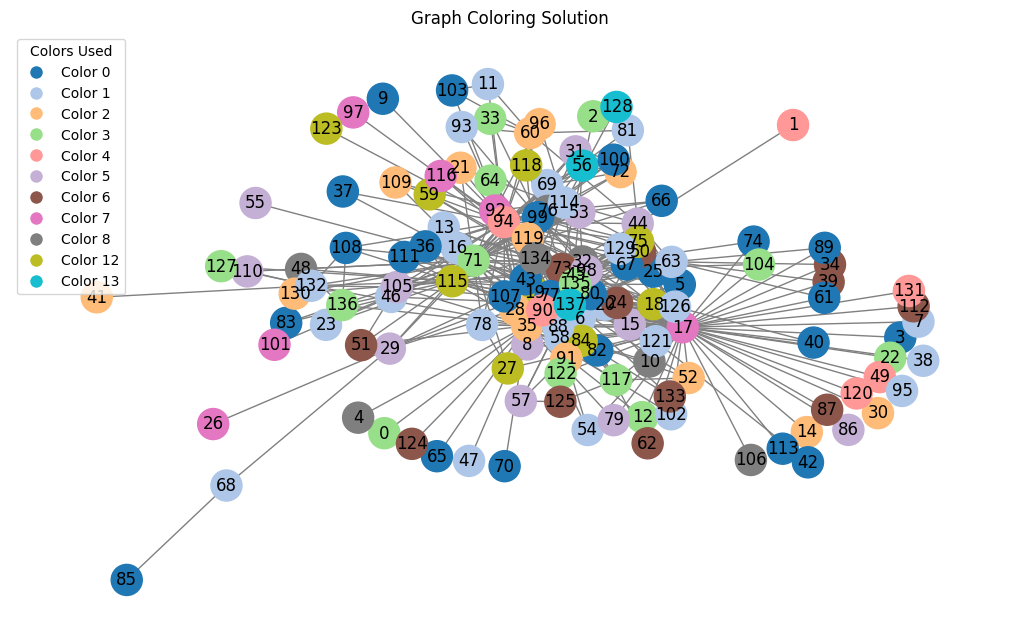

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming you already have:
# - V: Number of vertices
# - edges: List of edges
# - best_solution: List of colors assigned to each vertex

def visualize_graph_with_coloring(V, edges, best_solution):
    """
    Visualizes the graph with the final coloring applied and displays a legend for the colors.

    Parameters:
    - V: Number of vertices in the graph.
    - edges: List of edges in the graph.
    - best_solution: List of colors assigned to each vertex.
    """
    # Step 1: Create the graph from your existing data
    G = nx.Graph()
    G.add_nodes_from(range(V))  # Add all vertices
    G.add_edges_from(edges)     # Add all edges

    # Step 2: Assign colors to nodes
    node_colors = [best_solution[node] for node in range(V)]
    unique_colors = sorted(set(node_colors))  # Get unique colors used

    # Step 3: Use a colormap for distinct colors
    cmap = plt.cm.tab20  # A colormap with 20 distinct colors
    color_map = {color: cmap(i / len(unique_colors)) for i, color in enumerate(unique_colors)}

    # Map numeric colors to their RGB values
    node_color_rgb = [color_map[color] for color in node_colors]

    # Step 4: Draw the graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)  # Layout for visualization (spring layout is common)
    nx.draw(
        G,
        pos,
        node_color=node_color_rgb,
        with_labels=True,
        node_size=500,       # Size of nodes
        edge_color="gray",   # Color of edges
        font_color="black"   # Color of labels
    )

    # Step 5: Add a legend for the colors
    handles = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            label=f'Color {color}',
            markerfacecolor=color_map[color],
            markersize=10
        )
        for color in unique_colors
    ]
    plt.legend(handles=handles, title="Colors Used", loc="best")

    plt.title("Graph Coloring Solution")
    plt.show()



visualize_graph_with_coloring(V, edges, best_solution)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("results3.csv")

# **Fitness Over generations**

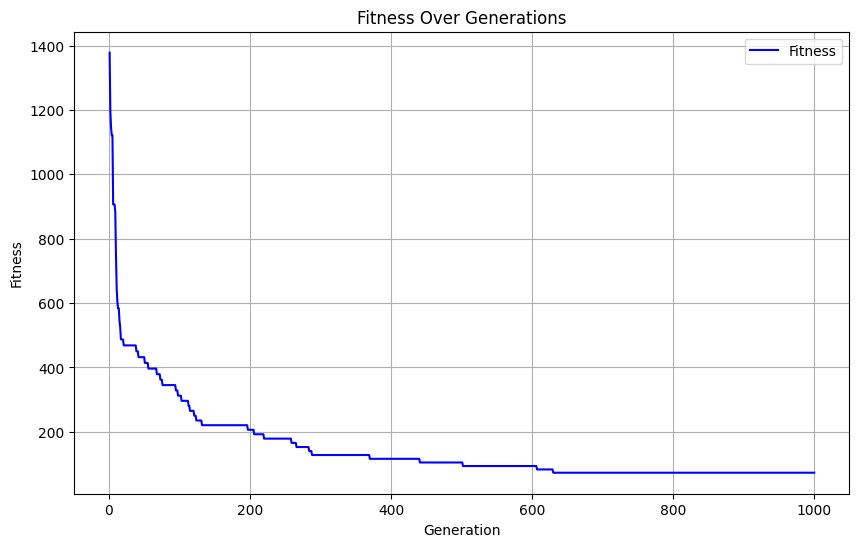

In [ ]:
# Plot fitness over generations
plt.figure(figsize=(10, 6))
plt.plot(df["Generation"], df["Fitness"], label="Fitness", color="blue")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Over Generations")
plt.legend()
plt.grid()
plt.show()


# **number of colors over generations**

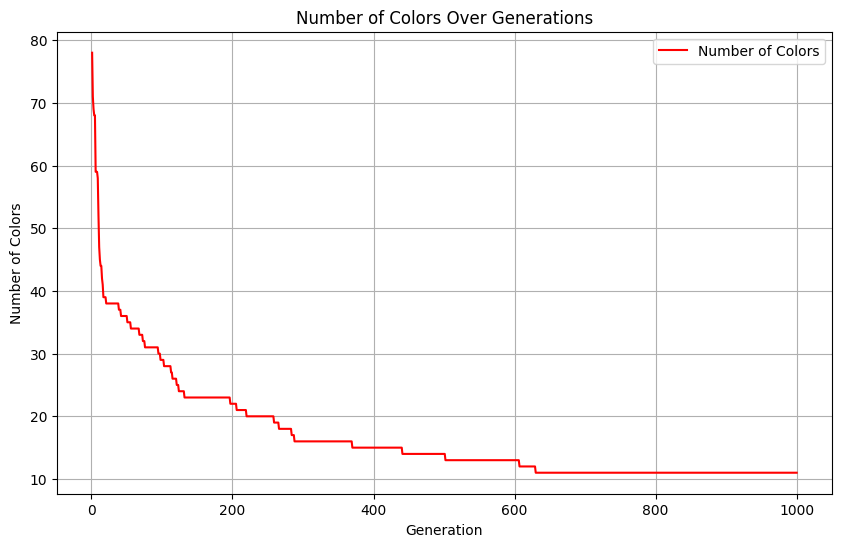

In [ ]:
# Plot number of colors over generations
plt.figure(figsize=(10, 6))
plt.plot(df["Generation"], df["Number of Colors"], label="Number of Colors", color="red")
plt.xlabel("Generation")
plt.ylabel("Number of Colors")
plt.title("Number of Colors Over Generations")
plt.legend()
plt.grid()
plt.show()

# **diversity over generations**

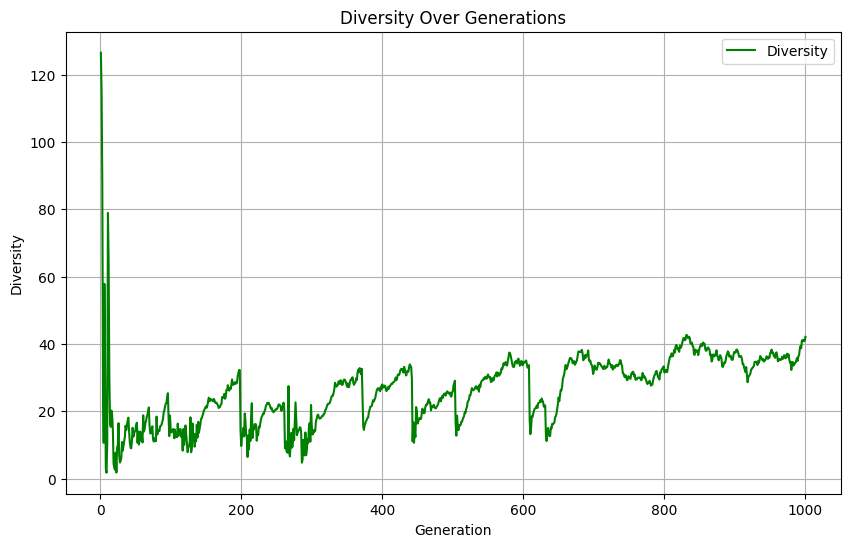

In [ ]:
# Plot diversity over generations
plt.figure(figsize=(10, 6))
plt.plot(df["Generation"], df["Diversity"], label="Diversity", color="green")
plt.xlabel("Generation")
plt.ylabel("Diversity")
plt.title("Diversity Over Generations")
plt.legend()
plt.grid()
plt.show()

# **mutation rate over generations**

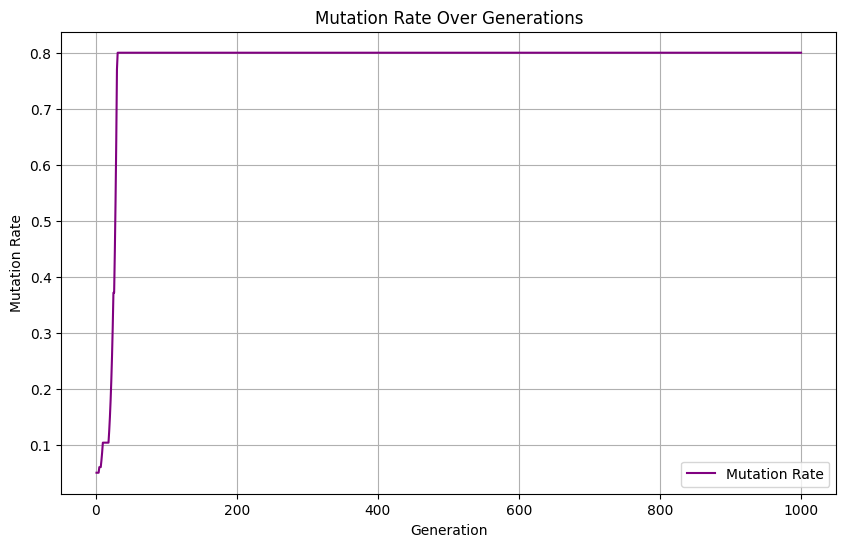

In [ ]:
# Plot mutation rate over generations
plt.figure(figsize=(10, 6))
plt.plot(df["Generation"], df["Mutation Rate"], label="Mutation Rate", color="purple")
plt.xlabel("Generation")
plt.ylabel("Mutation Rate")
plt.title("Mutation Rate Over Generations")
plt.legend()
plt.grid()
plt.show()

# **TEST2**

# **Run GA**

In [ ]:
if __name__ == '__main__':
    file_path = "/content/test2.txt"

    # Fonction pour lire un graphe depuis un fichier
    def read_graph(file_path):
        with open(file_path) as f:
            data = f.read().strip().split("\n")
        _, V, _ = data[0].split()
        V = int(V)
        edges = [(int(u) - 1, int(v) - 1) for _, u, v in (line.split() for line in data[1:] if line.strip())]
        return V, edges

    V, edges = read_graph(file_path)

    population_size = 50
    generations = 2000
    mutation_rate = 0.05
    alpha = 5
    beta = 2

    # Création de l'instance du GA
    ga = GraphColorGA(V, edges,population_size, generations, mutation_rate, alpha, beta )

    # Utilisation de la méthode evolve() pour obtenir la meilleure solution
    best_solution = ga.evolve()

    # Calcul du nombre de couleurs utilisées (par le nombre de couleurs uniques dans la solution)
    num_colors = len(set(best_solution))

    # Validation de la solution
    if validate_coloring(V, edges, best_solution):
        print("La solution est valide: Aucun conflit détecté.")
    else:
        print("La solution n'est pas valide: Conflits détectés.")

    print(f"Nombre de couleurs utilisées: {num_colors}")
    print(f"Meilleure solution: {best_solution}")

Generation: 1, Number of Colors: 313
Generation: 2, Number of Colors: 288
Generation: 3, Number of Colors: 272
Generation: 4, Number of Colors: 262
Generation: 5, Number of Colors: 257
Generation: 6, Number of Colors: 256
Generation: 7, Number of Colors: 255
Generation: 8, Number of Colors: 252
Generation: 9, Number of Colors: 250
Generation: 10, Number of Colors: 248
Generation: 11, Number of Colors: 246
Generation: 12, Number of Colors: 245
Generation: 13, Number of Colors: 244
Generation: 14, Number of Colors: 243
Generation: 15, Number of Colors: 242
Generation: 16, Number of Colors: 241
Generation: 17, Number of Colors: 241
Generation: 18, Number of Colors: 240
Generation: 19, Number of Colors: 240
Generation: 20, Number of Colors: 227
Generation: 21, Number of Colors: 227
Generation: 22, Number of Colors: 224
Generation: 23, Number of Colors: 218
Generation: 24, Number of Colors: 217
Generation: 25, Number of Colors: 215
Generation: 26, Number of Colors: 214
Generation: 27, Numbe

# **Visualisation**

In [ ]:
# Load the CSV file
import pandas as pd
df = pd.read_csv("results3.csv")

In [ ]:
df.head(10)

,Generation,Number of Colors,Fitness,Mutation Rate,Diversity
0,1,313,11075.070564,0.05,465.111837
1,2,288,9775.044143,0.05,397.226939
2,3,272,8971.877841,0.05,343.048980
3,4,262,8481.680965,0.05,323.218776
4,5,257,8240.046845,0.05,235.760000
5,6,256,8192.000000,0.05,192.988571
6,7,255,8144.046906,0.05,135.992653
7,8,252,8000.751965,0.05,151.430204
8,9,250,7905.694150,0.05,144.201633
9,10,248,7811.015811,0.05,118.615510


# **Colored Graph**

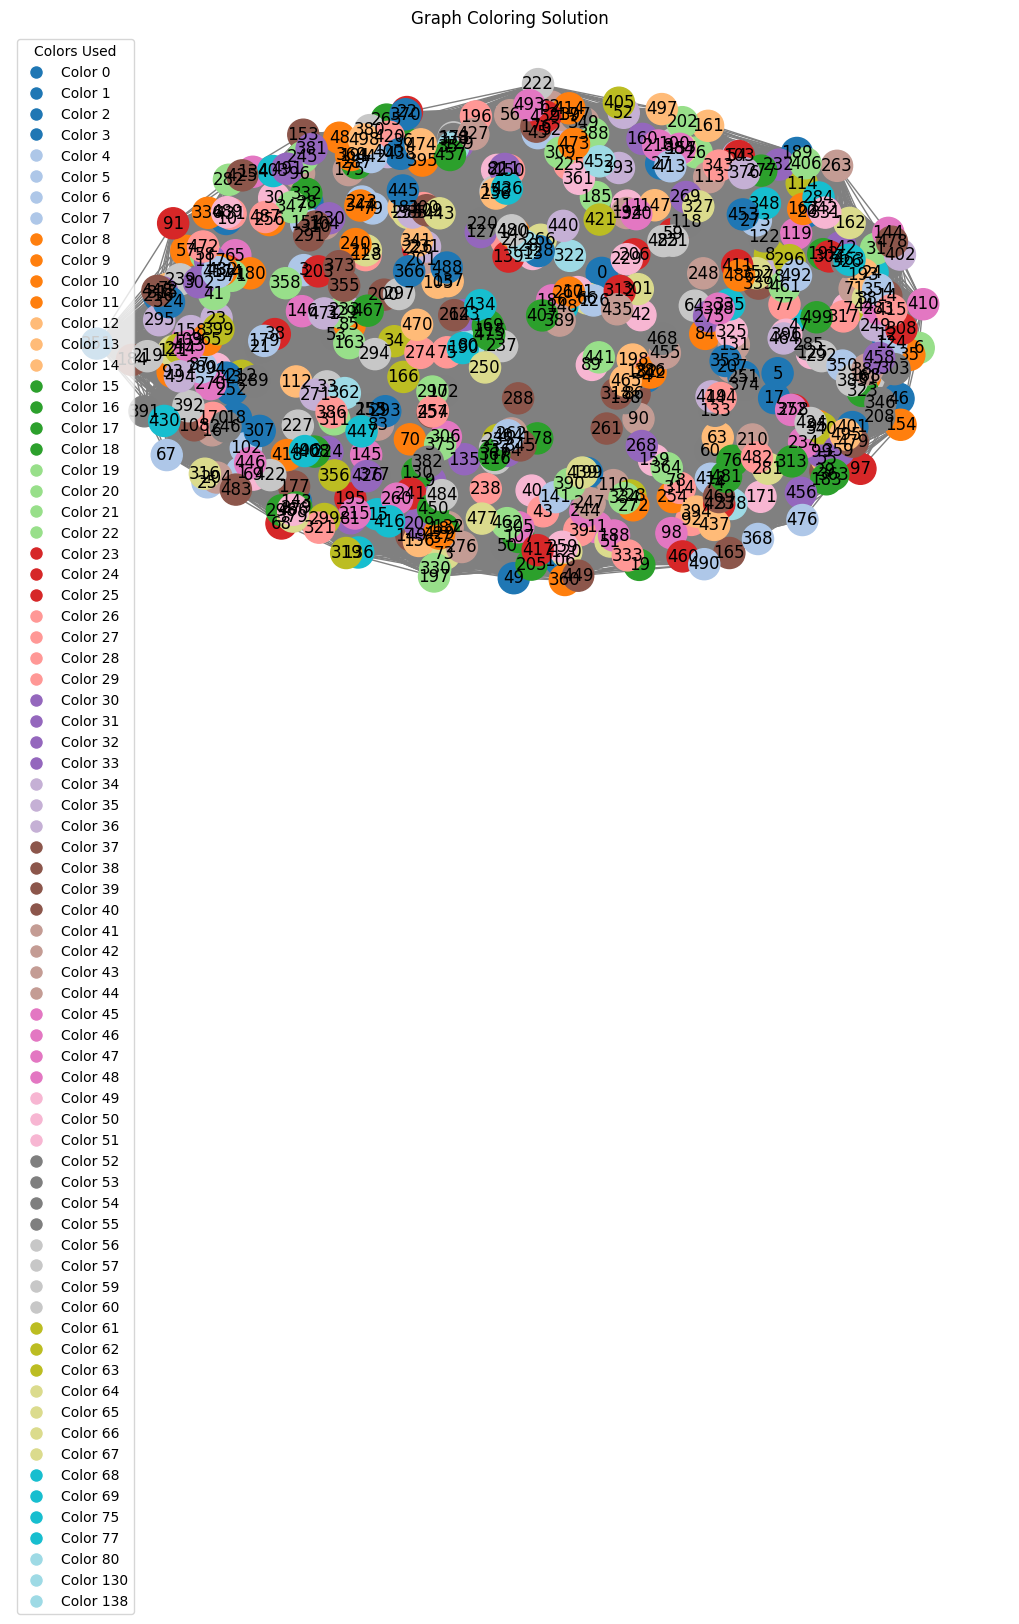

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming you already have:
# - V: Number of vertices
# - edges: List of edges
# - best_solution: List of colors assigned to each vertex

def visualize_graph_with_coloring(V, edges, best_solution):
    """
    Visualizes the graph with the final coloring applied and displays a legend for the colors.

    Parameters:
    - V: Number of vertices in the graph.
    - edges: List of edges in the graph.
    - best_solution: List of colors assigned to each vertex.
    """
    # Step 1: Create the graph from your existing data
    G = nx.Graph()
    G.add_nodes_from(range(V))  # Add all vertices
    G.add_edges_from(edges)     # Add all edges

    # Step 2: Assign colors to nodes
    node_colors = [best_solution[node] for node in range(V)]
    unique_colors = sorted(set(node_colors))  # Get unique colors used

    # Step 3: Use a colormap for distinct colors
    cmap = plt.cm.tab20  # A colormap with 20 distinct colors
    color_map = {color: cmap(i / len(unique_colors)) for i, color in enumerate(unique_colors)}

    # Map numeric colors to their RGB values
    node_color_rgb = [color_map[color] for color in node_colors]

    # Step 4: Draw the graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)  # Layout for visualization (spring layout is common)
    nx.draw(
        G,
        pos,
        node_color=node_color_rgb,
        with_labels=True,
        node_size=500,       # Size of nodes
        edge_color="gray",   # Color of edges
        font_color="black"   # Color of labels
    )

    # Step 5: Add a legend for the colors
    handles = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            label=f'Color {color}',
            markerfacecolor=color_map[color],
            markersize=10
        )
        for color in unique_colors
    ]
    plt.legend(handles=handles, title="Colors Used", loc="best")

    plt.title("Graph Coloring Solution")
    plt.show()



visualize_graph_with_coloring(V, edges, best_solution)

# **Fitness**

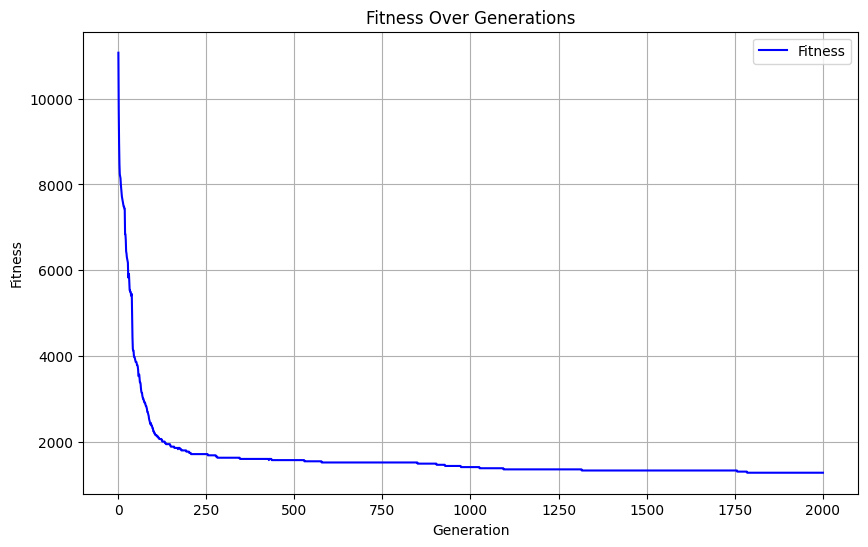

In [ ]:
# Plot fitness over generations
plt.figure(figsize=(10, 6))
plt.plot(df["Generation"], df["Fitness"], label="Fitness", color="blue")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Over Generations")
plt.legend()
plt.grid()
plt.show()

# **Num of colors**

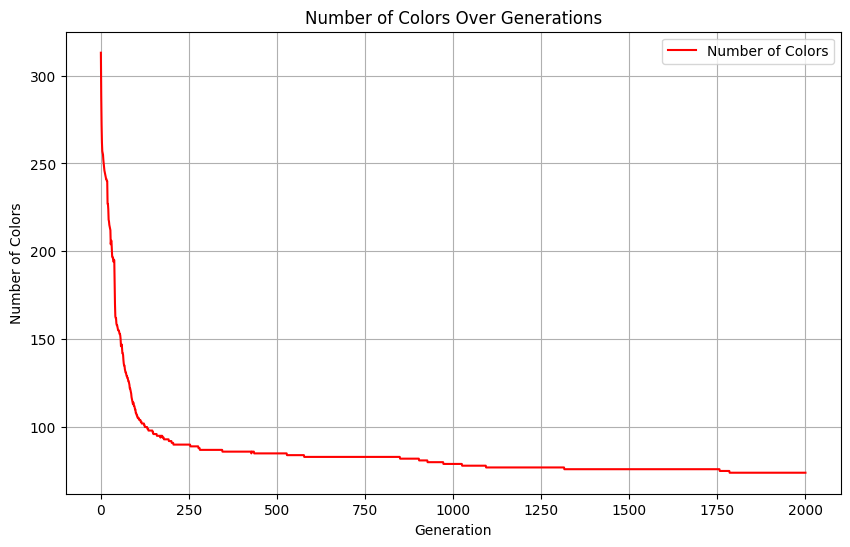

In [ ]:
# Plot number of colors over generations
plt.figure(figsize=(10, 6))
plt.plot(df["Generation"], df["Number of Colors"], label="Number of Colors", color="red")
plt.xlabel("Generation")
plt.ylabel("Number of Colors")
plt.title("Number of Colors Over Generations")
plt.legend()
plt.grid()
plt.show()

# **Diversity**

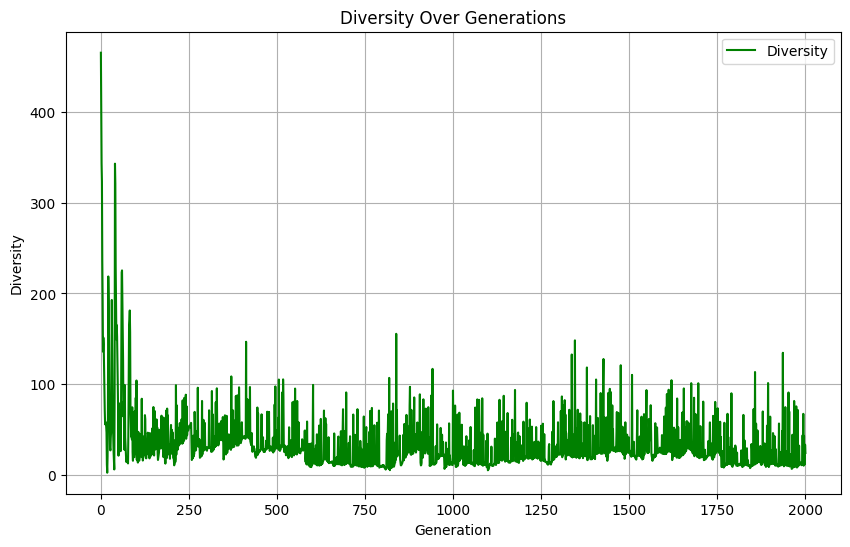

In [ ]:
# Plot diversity over generations
plt.figure(figsize=(10, 6))
plt.plot(df["Generation"], df["Diversity"], label="Diversity", color="green")
plt.xlabel("Generation")
plt.ylabel("Diversity")
plt.title("Diversity Over Generations")
plt.legend()
plt.grid()
plt.show()

# **Mutation Rate**

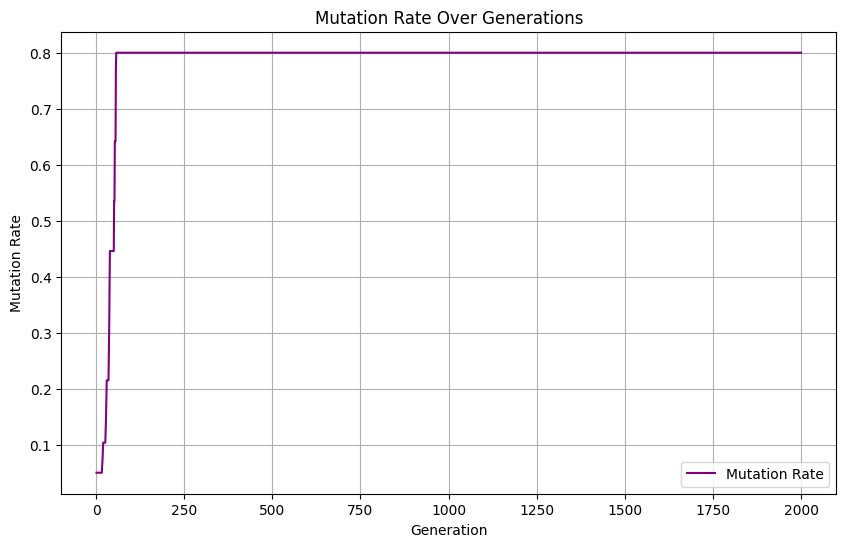

In [ ]:
# Plot mutation rate over generations
plt.figure(figsize=(10, 6))
plt.plot(df["Generation"], df["Mutation Rate"], label="Mutation Rate", color="purple")
plt.xlabel("Generation")
plt.ylabel("Mutation Rate")
plt.title("Mutation Rate Over Generations")
plt.legend()
plt.grid()
plt.show()